# Imports

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared,
    ConstantKernel,
    Matern,
)
from sklearn.preprocessing import StandardScaler

# Dataset and Preprocessing

In [95]:
df_test = pd.read_csv("../data/DailyDelhiClimateTest.csv")
df_train = pd.read_csv("../data/DailyDelhiClimateTrain.csv")

df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])

df_train = df_train.set_index("date")
df_test = df_test.set_index("date")

In [96]:
target_col = "meantemp"
feature_cols = ["humidity", "wind_speed", "meanpressure"]

y_train = df_train[target_col]
X_train = df_train[feature_cols]
y_test = df_test[target_col]
X_test = df_test[feature_cols]

In [97]:
print(df_train.head())
print(df_test.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333


# Modelling
In this section we compute our Gaussian Process Models. We define some helper functions to facilitate the process.

In [98]:
def create_gp_plot(X_test, y_test, gp_mean, st_dev):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

    # realizations in the background
    ax1.fill_between(
        X_test,
        gp_mean - 0 * st_dev,
        gp_mean + 0 * st_dev,
        color="red",
        alpha=0.05,
        label="$2 \sigma$",
    )
    for i in range(1, 5):
        ax1.fill_between(
            X_test,
            gp_mean - 0.5 * i * st_dev,
            gp_mean + 0.5 * i * st_dev,
            color="red",
            alpha=0.05,
        )
    # original function
    # ax1.plot(X2, func(X2), "b--", label="$sin(x)$")

    # confidence interval of 2 stdev

    ax1.plot(X_test, gp_mean, "r-", lw=2, label="$\mu^{*}$")
    ax1.plot(X_test, y_test, "ko", linewidth=2, label="$(x_n, y_n)$")
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$f(x)$")
    ax1.set_title("Gaussian Process Regression")
    # ax1.axis([domain[0], domain[1], -3, 3])
    ax1.legend(loc=2)
    return fig

## Basic Model
We start with a very simple Model using a RBF kernel and assess its performance.

In [106]:
model = gp.GaussianProcessRegressor(
    kernel=RBF(), n_restarts_optimizer=10, alpha=0.1, normalize_y=True
)

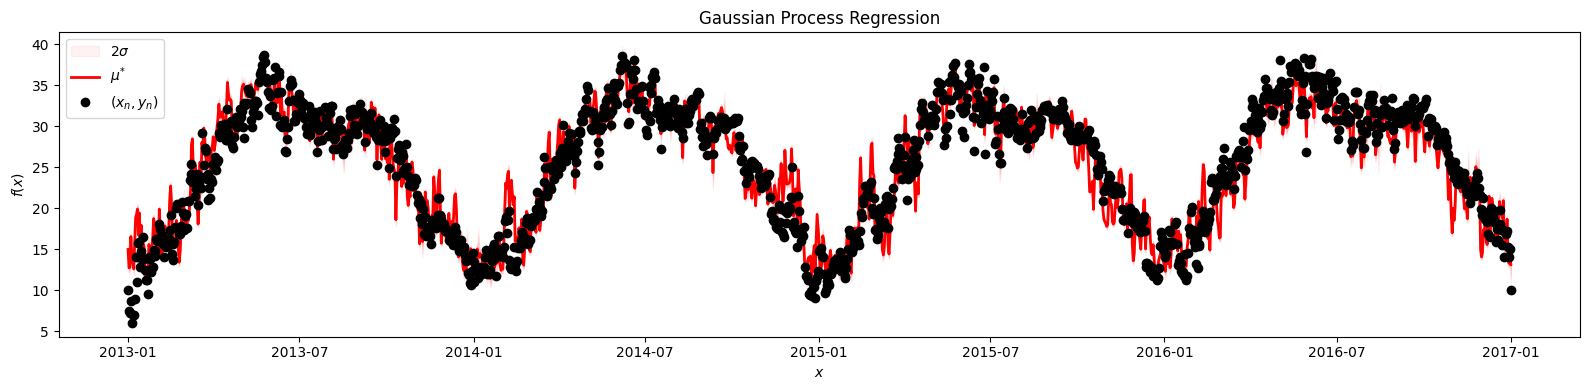

In [107]:
model.fit(X_train, y_train)

y_pred, std = model.predict(X_train, return_std=True, return_cov=False)
gp_mean = model.predict(X_train)

fig = create_gp_plot(X_train.index.to_list(), y_train, gp_mean, std)
plt.tight_layout()
plt.show()

In [108]:
model.score(X_train, y_train)

0.8991913680604561

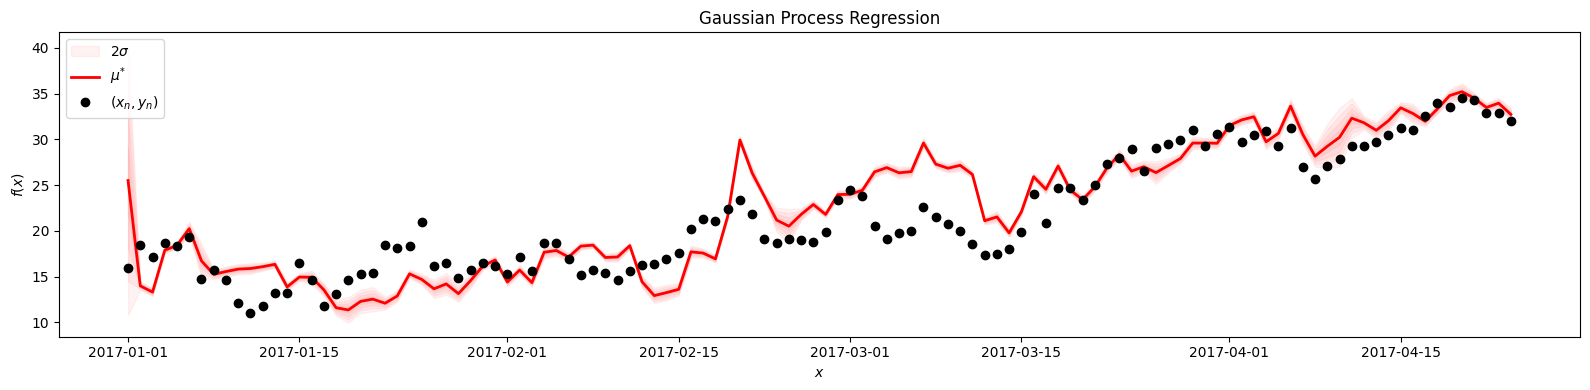

In [101]:
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)
gp_mean = model.predict(X_test)

fig = create_gp_plot(X_test.index.to_list(), y_test, gp_mean, std)
plt.tight_layout()
plt.show()

In [102]:
model.score(X_test, y_test)

0.7388840176921558

## Tuned Model

In [103]:
kernel = RBF() + WhiteKernel(noise_level=0.1) + ExpSineSquared(length_scale=1.0)

model = gp.GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True
)
model.fit(X_train, y_train)
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)
gp_mean = model.predict(X_test)

/home/lukas/.local/share/virtualenvs/prob-ml-project-acRXiJBF/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


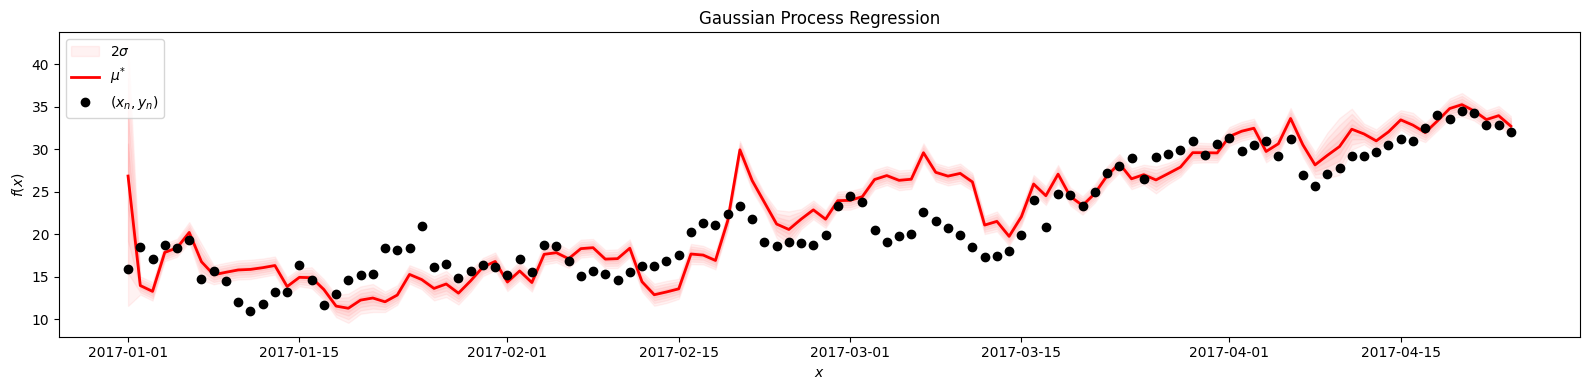

In [104]:
fig = create_gp_plot(X_test.index.to_list(), y_test, gp_mean, std)
plt.tight_layout()
plt.show()

In [105]:
model.score(X_test, y_test)

0.7324530919995347